In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, Categorical

import gym
from PPO import PPO

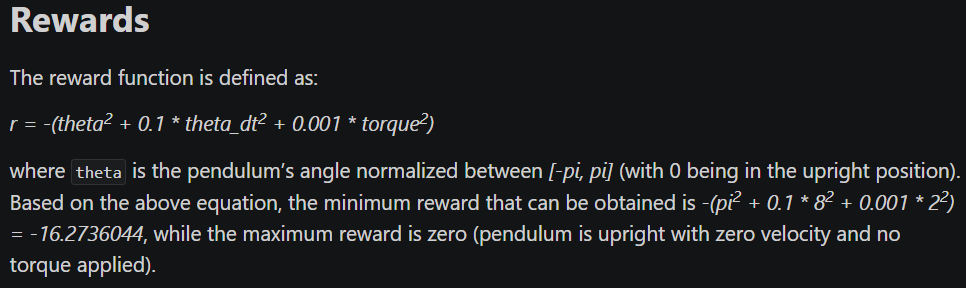

In [43]:
################################## set device ##################################
print("============================================================================================")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device set to : " + str(torch.cuda.get_device_name(device)))
print("============================================================================================")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.values = []
        self.dones = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.values[:]
        del self.dones[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space
        
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError
    
    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.values.append(state_val)

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.values.append(state_val)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss  
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy  # original
            # x.mean()+y.mean() = (x+y.mean()).mean()

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        

Device set to : NVIDIA GeForce RTX 3060 Laptop GPU


training environment name : Pendulum-v1
Episode : 9 		 Timestep : 6000 		 Average Reward : -3263.23
Episode : 19 		 Timestep : 12000 		 Average Reward : -3978.1
Episode : 29 		 Timestep : 18000 		 Average Reward : -3395.6
Episode : 39 		 Timestep : 24000 		 Average Reward : -3206.0
Episode : 49 		 Timestep : 30000 		 Average Reward : -2856.9
Episode : 59 		 Timestep : 36000 		 Average Reward : -2960.82
Episode : 69 		 Timestep : 42000 		 Average Reward : -2784.91
Episode : 79 		 Timestep : 48000 		 Average Reward : -2974.85
Episode : 89 		 Timestep : 54000 		 Average Reward : -2556.53
Episode : 99 		 Timestep : 60000 		 Average Reward : -2627.45
Episode : 109 		 Timestep : 66000 		 Average Reward : -2621.33
Episode : 119 		 Timestep : 72000 		 Average Reward : -2496.6
Episode : 129 		 Timestep : 78000 		 Average Reward : -2654.66
Episode : 139 		 Timestep : 84000 		 Average Reward : -2522.27
Episode : 149 		 Timestep : 90000 		 Average Reward : -2615.13
Episode : 159 		 Timestep : 9600

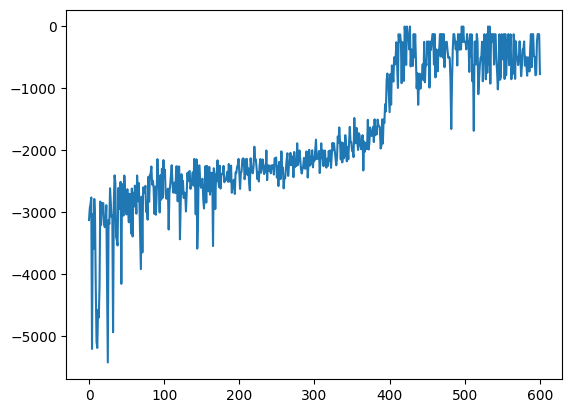

Total training time  :  0:13:53


In [ ]:

################################### Training ###################################

print("============================================================================================")

####### initialize environment hyperparameters ######
env_name = "Pendulum-v1"

is_continuous = True  # continuous action space; else discrete

max_ep = 600
max_ep_len = 600                    # max timesteps in one episode
max_timesteps = max_ep*max_ep_len   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)
save_model_freq = int(1e5)          # save model frequency (in num timesteps)

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)
#####################################################


################ PPO hyperparameters ################
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 60           # update policy for K epochs in one PPO update

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)
#####################################################

print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if is_continuous:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

###################### logging ######################
directory = os.getcwd()

#### log files for multiple runs are NOT overwritten
log_dir = directory + "/" + "PPO_logs"
if not os.path.exists(log_dir):
        os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
        os.makedirs(log_dir)

#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)

#### create new log file for each run
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

# print("current logging run number for " + env_name + " : ", run_num)
# print("logging at : " + log_f_name)
#####################################################


################### checkpointing ###################
run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

chkpt_dir = directory + "/" + "PPO_preTrained"
if not os.path.exists(chkpt_dir):
        os.makedirs(chkpt_dir)

chkpt_dir = chkpt_dir + '/' + env_name + '/'
if not os.path.exists(chkpt_dir):
        os.makedirs(chkpt_dir)


checkpoint_path = chkpt_dir + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
# print("save checkpoint path : " + checkpoint_path)
#####################################################


################# training procedure ################
# initialize a PPO agent
agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, is_continuous, action_std)

# track total training time
start_time = datetime.now().replace(microsecond=0)

print("============================================================================================")

# logging file
# log_f = open(log_f_name,"w+")
# log_f.write('episode,timestep,reward\n')

# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

episode_reward = []

# training loop
while time_step <= max_timesteps:

    state, _ = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):

        # select action with policy
        action = agent.select_action(state)
        state, reward, done, truncation, _ = env.step(action)

        # saving reward and is_terminals
        agent.buffer.rewards.append(reward)
        agent.buffer.dones.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if is_continuous and time_step % action_std_decay_freq == 0:
            agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            # log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            # log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0

        # save model weights
        if time_step % save_model_freq == 0:
            # print("--------------------------------------------------------------------------------------------")
            # print("saving model at : " + checkpoint_path)
            agent.save(checkpoint_path)
            # print("model saved")
            # print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            # print("--------------------------------------------------------------------------------------------")

        # break; if the episode is over
        if done:
            break
    
    episode_reward.append(current_ep_reward)

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1

# log_f.close()
env.close()

plt.plot(episode_reward)
plt.show()

# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

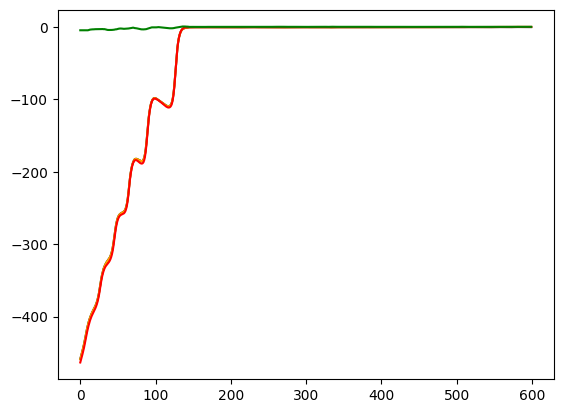

In [85]:
reward_arr = np.array(agent.buffer.rewards)
done_arr = np.array(agent.buffer.dones)
val_arr = torch.stack(agent.buffer.values).flatten().cpu().numpy()

###  return 反向计算 不考虑last value ###
returns = []
discounted_reward =0
for reward, done in zip(reversed(reward_arr), reversed(done_arr)):
    if done:
        discounted_reward = 0
    discounted_reward = reward + (agent.gamma * discounted_reward)
    returns.insert(0, discounted_reward)

###  advantage MC计算 ###
advantages_mc = returns - val_arr
returns = np.array(returns)
returns_normal = (returns - returns.mean()) / (returns.std() + 1e-7)
advantages_normal = returns_normal - val_arr


##  advantage 反向计算 ###
T = len(reward_arr)  # buffer长度
advantages = np.zeros(T, dtype=np.float32)
gae = 0
for t in reversed(range(T-1)):  # atten 此处，最后一项优势函数假设为0，或存储last_state以计算last_value. 目前假设为0，效果更好些
    delta_t = reward_arr[t] + agent.gamma*val_arr[t+1]*(1-int(done_arr[t])) - val_arr[t]
    gae = delta_t + agent.gamma*gae*(1-int(done_arr[t]))

    advantages[t] = gae


plt.plot(advantages_mc, c='black')
plt.plot(advantages, c='orange')
plt.plot(returns, c='red')  # 反向计算, 考虑v(s_T)
# plt.plot(returns_, c='blue')  # advantages + val_arr = v_target = returns with last value
plt.plot(val_arr, c = 'green')  # value array

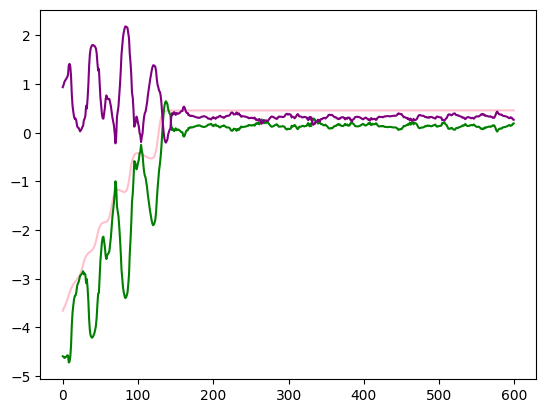

In [ ]:
## advantage = returns - valures
plt.plot(returns_normal, c='pink')
plt.plot(val_arr, c = 'green')  # value array
plt.plot(advantages_normal, c = 'purple')  # value array

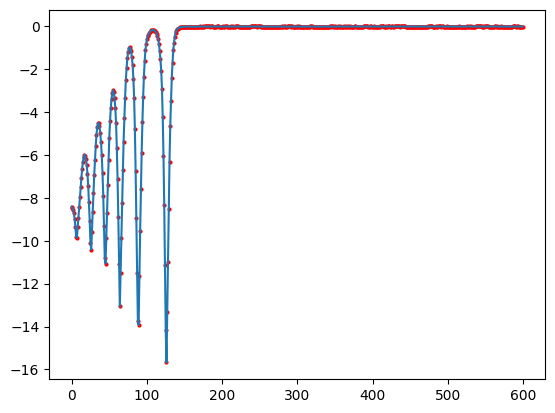

In [90]:
plt.plot(reward_arr)
plt.scatter(np.arange(len(reward_arr)), reward_arr, s=4, c='r')